In [1]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import pandas as pd
import warnings
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=UserWarning, message="Converting data to scipy sparse matrix.")

## Training data 

In [2]:
df_train= pd.read_csv("./data/cleaned_actual.csv")
df_train = df_train.rename(columns={"Time": 'time', 
                                 "Load (kW)": "load_kw_true", 
                                 "Pressure_kpa": "pres_kpa_true",
                                 'Cloud Cover (%)': 'cld_pct_true',
                                 'Humidity (%)': 'hmd_pct_true',
                                 'Temperature (C)': 'temp_c_true',
                                 'Wind Direction (deg)': 'wd_deg_true',
                                 'Wind Speed (kmh)':'ws_kmh_true'})
df_train['time'] = pd.to_datetime(df_train['time'])

## Testing data and Validation data
`./data/cleaned_actual_train_test.csv` contain training and testing data which missing testing data is inputed with naive method. First the data is shifted, then extract the testing data, which is after 2021-01-17 08:00:00

In [3]:
#imputed testing and training data set
df_full= pd.read_csv("./data/cleaned_actual_train_test.csv")
df_full = df_full.rename(columns={"Time": 'time', 
                                 "Pressure (kpa)": "pres_kpa_pred",
                                 'Cloud Cover (%)': 'cld_pct_pred',
                                 'Temperature (C)': 'temp_c_pred',
                                 'Wind Direction (deg)': 'wd_deg_pred',
                                 'Wind Speed (kmh)':'ws_kmh_pred'})
df_full['time'] = pd.to_datetime(df_full['time'])
df_full.set_index('time', inplace=True)
df_full.index = df_full.index.tz_convert('+11:00')
#df_test.to_csv("./data/cleaned_actual_test.csv")

In [4]:
#start and end date of training and validation data
end_date = pd.to_datetime(df_train['time'].iloc[-1])
start_date = end_date - pd.DateOffset(years=3)

#extract 3 years of data, which is training and validation data
train_val_data = df_train.loc[df_train['time'].between(start_date, end_date)]

#drop time axis
train_val_data.index = train_val_data['time']
train_val_data = train_val_data.drop('time', axis=1)

#split training and validation data 
n = len(train_val_data)
train_data = train_val_data[:int(n*0.9)]
val_data= train_val_data[int(n*0.9):]

## Model

In [5]:
class XGBoost():
    param_grid = [
        {'max_depth': depth, 'eta': eta, 'subsample': subsample, 'colsample_bytree': colsample_bytree,
        'objective': 'reg:absoluteerror', 'eval_metric': 'mae'}
        for depth in range(2, 11, 2)
        for eta in [i / 10 for i in range(1, 4)]
        for subsample in [i / 10 for i in range(5, 11)]
        for colsample_bytree in [i / 10 for i in range(5, 11)]
    ]

    def __init__(self, history_data: pd.DataFrame =False, model_file=""):
        if model_file:
            self.model = xgb.Booster(model_file=model_file)
        else:
            self.train_data, self.val_data = self.preprocess(history_data)
            self.model, self.params, self.mae = self.train_best_model(self.train_data, self.val_data, self.param_grid)
    
    def preprocess(self, history_data, xgb_pred = None):
        if xgb_pred == None:
            xgb_pred = []
            
        train_val_data = pd.DataFrame([])
        for i in range(24, 169, 24):
            key = 'load_kw_lag' + str(i)
            shift_col =  history_data['load_kw'].shift(i).rename(key)
            train_val_data = pd.concat([train_val_data, shift_col], axis=1)
            #train_val_data[key] = history_data['load_kw'].shift(i)

        train_val_data = pd.concat([train_val_data, history_data['load_kw']], axis=1)
        #train_val_data['load_kw'] = history_data['load_kw']

        #train_val_data = train_val_data.drop('time_lag168', axis=1) #drop time_lag168
        #train_val_data.index = history_data.index #retrieve 'time' as index

        train_val_data= train_val_data.dropna(axis=0) #drop rows with NA values (due to shift)


        n = len(train_val_data)
        return train_val_data[:int(n*0.9)], train_val_data[int(n*0.9):]
    
    def predict(self, history_data, xgb_pred=None):
        if xgb_pred == None:
            xgb_pred = []
        X_pred = pd.DataFrame([])
        for i in range(0, 145, 24): #lag24,lag48, ..., lag168
            #shift load 
            X_pred = pd.concat([X_pred, history_data['load_kw'].shift(i).rename('load_kw_lag' + str(i+24))], axis=1)
    
        #X_pred['load_kw'] = history_data['load_kw']
        X_pred = X_pred.dropna(axis=0)
        X_pred.index = X_pred.index + pd.Timedelta(hours=24) #shift index time
        
        for i in range(len(X_pred)):
            #time = time_now + timedelta(hours=i) #increment 'time'
            X = X_pred.iloc[i,:] #1 hour of predictors
            xgb_pred.append(float(self.model.predict(X)))

        if len(xgb_pred) <=24:
            new_df = pd.DataFrame({'load_kw':xgb_pred}, index=pd.date_range(history_data.index[-1] + pd.Timedelta(hours=1), periods=len(xgb_pred), freq='H'))
            history_data = pd.concat([history_data, new_df])
            return self.predict(history_data[24:], xgb_pred=xgb_pred)
        
        else:
            return xgb_pred
    
    def train_best_model(self, train_data, val_data, param_grid):
        """
        This function trains an XGBoost model using a grid search over the parameter grid 
        and returns the model with the smallest mean absolute error (MAE) on the validation data.
        
        Args:
        train_data (pd.DataFrame): The training data.
        val_data (pd.DataFrame): The validation data.
        param_grid (dict): The grid of parameters to search over.
        
        Returns:
        best_model (xgb.Booster): The model with the smallest MAE on the validation data.
        best_params (dict): The parameters of the best model.
        best_mae (float): The MAE of the best model on the validation data.
        """
        
        best_model = None
        best_params = None
        best_mae = float('inf')
        
        # Extract features and labelsx
        X_train = train_data.loc[:, ~train_data.columns.isin(['load_kw'])]
        y_train = train_data['load_kw']
        X_val = val_data.loc[:, ~val_data.columns.isin(['load_kw'])]
        y_val = val_data['load_kw']
        #print(X_train.info(), y_train.info())
        
        # Create DMatrix
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        
        print('training model: XGBoost')

        # Iterate over all combinations of parameters
        for params in tqdm(param_grid):
            model = xgb.train(params, dtrain, 
                            num_boost_round=100, 
                            evals=[(dtrain, 'train'), (dval, 'val')], 
                            early_stopping_rounds=10, verbose_eval=False)

            # Predict on validation set and calculate MAE
            val_preds = model.predict(dval)
            mae = mean_absolute_error(y_val, val_preds)

            # Update best model if current model has lower MAE
            if mae < best_mae:
                best_model = model
                best_params = params
                best_mae = mae

        return best_model, best_params, best_mae



In [6]:
#model_xgb = XGBoost(history_data = train_val_data)
#model_xgb.model.save_model("./xbg_model.json") #save model
model_xgb =XGBoost(model_file="./xbg_model.json")

## First 24 hour Prediction Data

In [7]:
#create lags
test_data_1 = pd.DataFrame([])
for i in range(24, 169, 24): #lag24,lag48, ..., lag168
    #shift load 
    test_data_1 = pd.concat([test_data_1, df_full['load_kw'].shift(i).rename('load_kw_lag' + str(i))], axis=1)
test_data_1 = pd.concat([test_data_1, df_full['load_kw']], axis=1) #extract label

#starting date of testing data
test_data_start_time = pd.to_datetime('2021-01-17 08:00:00').tz_localize('UTC').tz_convert('+11:00')

#extract testing data
test_data_1 = test_data_1[test_data_1.index >= test_data_start_time]

In [8]:
y_test_1 = test_data_1['load_kw']
y_pred_1 = model_xgb.model.predict(xgb.DMatrix(test_data_1.drop('load_kw', axis=1)))
mae1 = mean_absolute_error(y_test_1, y_pred_1)
print(mae1)

15582.70791666667


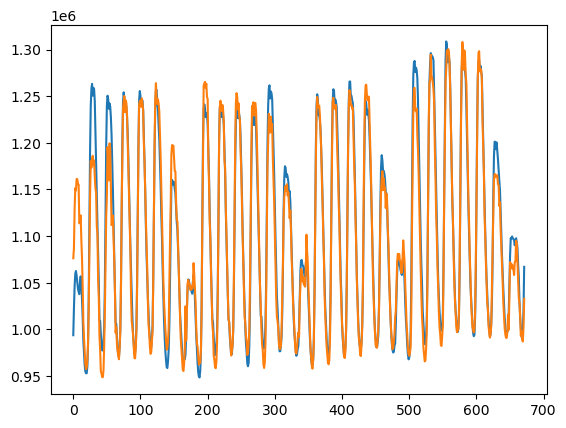

In [9]:
time = list(y_test_1.index)
plt.plot(list(y_test_1))
plt.plot(y_pred_1)
plt.show()

## Last 24 Hour Prediction Data
24 hour lag is imputed with predicted data 

In [10]:
#create lags
test_data_2 = pd.DataFrame([])
for i in range(24, 145, 24): #lag24,lag48, ..., lag168
    #shift load 
    test_data_2 = pd.concat([test_data_2, df_full['load_kw'].shift(i).rename('load_kw_lag' + str(i+24))], axis=1)
test_data_2 = pd.concat([test_data_2, df_full['load_kw']], axis=1) #extract label

#starting date of testing data
test_data_start_time = pd.to_datetime('2021-01-17 08:00:00').tz_localize('UTC').tz_convert('+11:00')

#extract testing data
test_data_2 = test_data_2[test_data_2.index >= test_data_start_time]

#24 hour lag is imputed with predicted data 
lag24 = pd.DataFrame({'load_kw_lag24':y_pred_1}, index = test_data_2.index)
test_data_2 = pd.concat([lag24, test_data_2], axis=1) 

In [11]:
y_test_2 = test_data_2['load_kw']
y_pred_2 = model_xgb.model.predict(xgb.DMatrix(test_data_2.drop('load_kw', axis=1)))
mae2 = mean_absolute_error(y_test_2[24:], y_pred_2[:-24])
print(mae2)

19979.2043867284


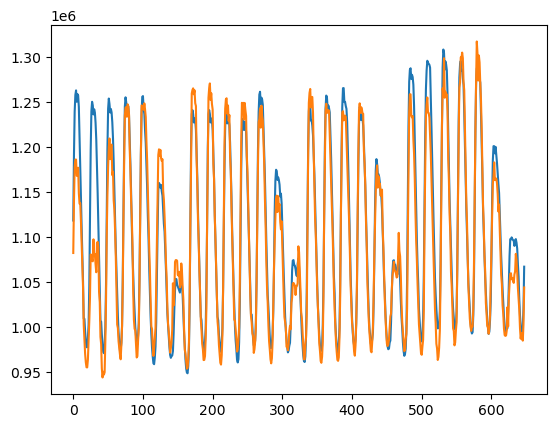

In [12]:
time = list(y_test_2.index)
plt.plot(list(y_test_2[24:]))
plt.plot(y_pred_2[:-24])
plt.show()

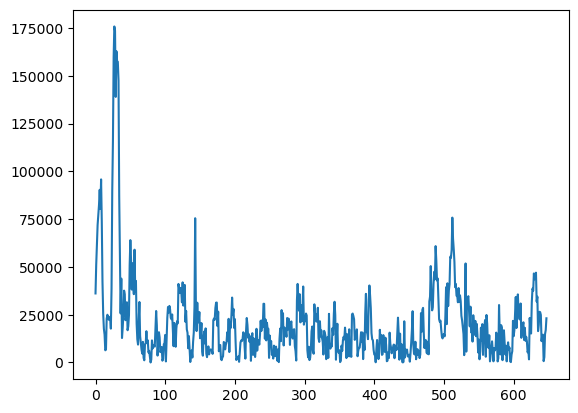

In [13]:
plt.plot(abs(list(y_test_2[24:])-y_pred_2[:-24]))
plt.show()